# **1 Preliminary Steps**

## **1.1  Goals**

Исследование возможности использования нейросетевых методов без  механизма обратного распространения ошибки на примере классификации изображений предметов одежды из набора данных  Fashion MNIST

## **1.2 Approaches**

Альтернативами обратному распространению ошибки выбраны:

1.  Обобщение метода наименьших квадратов для нейронных сетей  Extreme Learning
2.  Использование метрического метода k-NN для признаков из скрытого слоя нейросети

## **1.4 Installing the Required Modules**

In [1]:
!pip install faiss-cpu
!pip install timm
!pip install kornia
!pip install kornia[x]
!pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0


## **1. 3 Importing the Required Modules**

In [2]:
import os

import numpy as np
import pandas as pd

import cv2

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import kornia as K
from kornia.augmentation.container import AugmentationSequential

import faiss
import timm

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso


## **1.5 Downloading Kaggle Competition Data**

In [3]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c mds-ufu-dl-test
!unzip mds-ufu-dl-test.zip

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 from google.colab import files                                                               │
│   2 uploaded = files.upload()                                                                    │
│   3 get_ipython().system('mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.k     │
│   4 get_ipython().system('kaggle competitions download -c mds-ufu-dl-test')                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'google.colab'

# **2 Extreme Learning Approach**

Extreme learning machines - алгоритм обучения нейронных сетей прямого распространения с одним скрытым слоем  (реже многослойных), где веса входного и скрытых слоев инициализируются с случайным образом и не обновляются в процессе обучения. Для обучения таких сетей  используется обобщенный метод Мура-Пенроуза.

К достоинствам  ELM можно отнести:


*   в том что они обучаются гораздо быстрее, чем нейросетевые алгоритмы на основе обратного распространения ошибки, так отсутствует необходимость подбора параметров многократным проходом по данным;
*   вычислительная сложность гораздо ниже чем глубоких нейросетей, что позволяет их использовать во встраиваемых решениях;
*   возможность онлайн обучения по мере поступления данных.

Основной недостаток ЕLM более низкая обобщающая способность чем у глубоких нейросетей и поэтому при решении реальных задач может возникнуть проблема  дополнительного ансамблирования, например как в работе [5]


## **2.1 ELM References**

1. Huang, Guang-Bin; Hongming Zhou; Xiaojian Ding; and Rui Zhang (2012).
  "Extreme Learning Machine for Regression and Multiclass Classification" (PDF). IEEE Transactions on Systems, Man, and Cybernetics - Part B: Cybernetics. 42 (2): 513–529
2. https://en.wikipedia.org/wiki/Extreme_learning_machine#:~:text=Extreme%20learning%20machines%20are%20feedforward,hidden%20nodes)%20need%20not%20be
3. https://medium.com/analytics-vidhya/a-gentle-introduction-to-extreme-learning-machines-elm-91bb793effa8
4. https://en.wikipedia.org/wiki/Moore–Penrose_inverse
5. Liu, Zhi and Yang, Shuyuan and Feng, Zhixi and Gao, Quanwei and Wang, Min (2021). Fast SAR Autofocus Based on Ensemble Convolutional Extreme Learning Machine. Remote Sensing 13 (14): 2683

## **2.2 Fashion MNIST DataLoader**

In [ ]:
class FMNISTtDataset(data.Dataset):

  def __init__(self, np_data, use_augmentation=True):

     self.np_data = np_data
     self.img_sz = (28, 28)
     self.use_augmentation = use_augmentation

     if self.np_data.shape[0] == 0:
        raise RuntimeError('dataset is empty')

     self.geometry_augmentations = AugmentationSequential(
                K.augmentation.RandomHorizontalFlip(p=1., same_on_batch=False,),             #1
                K.augmentation.RandomVerticalFlip(p=1.,   same_on_batch=False),              #2
                K.augmentation.RandomAffine(degrees=(-5., 5.), p=1., scale=(.9, 1.2),        #3
                                                      shear=(-5., 5.), same_on_batch=False),
                K.augmentation.RandomRotation(degrees=(-5., 5.), p=1., same_on_batch=False), #4
      data_keys=['input'],
      random_apply=1,
      random_apply_weights=[0.25, 0.25, 0.25, 0.25,],
      same_on_batch=False
     )

  def __len__(self):
     return self.np_data.shape[0]

  def __getitem__(self, idx):
     img = self.np_data[idx, 1 :]
     lbl = int(self.np_data[idx, 0])

     img = np.reshape(img, self.img_sz)

     out_tensor = torch.from_numpy(np.array(img)).float() / 255.0
     if self.use_augmentation:
        out_tensor = self.geometry_augmentations(out_tensor)
     if len(out_tensor.shape) == 4:
        out_tensor = torch.squeeze(out_tensor, dim=0)
     if len(out_tensor.shape) == 2:
        out_tensor = torch.unsqueeze(out_tensor, dim=0)
     return out_tensor, lbl

def to_numpy_data(df)->np.ndarray:
    numpy_data =[]
    for idx in range(len(df)):
       numpy_data.append([df.iloc[idx, jdx] for jdx in range(len(df.columns))])

    numpy_data = np.array(numpy_data)
    return numpy_data

def get_test_train_data(root_dir, train_csv = "fmnist_train.csv", train_sz = .8, random_state = 26):
  df = pd.read_csv(os.path.join(root_dir, train_csv))
  df.iloc[:, 1:-1] = df.iloc[:, 1:-1].fillna(0)
  df.drop(columns=["Id"], inplace=True)
  train_df, test_df = train_test_split(df, test_size=1-train_sz, random_state=random_state, stratify=df[["label"]])
  train_data = to_numpy_data(train_df)
  test_data = to_numpy_data(test_df)
  return train_data, test_data

def read_ml_data(path):
  if not os.path.isfile(path):
     return np.array([])
  with open(path, "rb") as f:
    np_data = np.load(path)
  return np_data

def save_ml_data(path, data) -> None:
   if not path:
     return
   with open(path, "wb") as f:
      np.save(f, data)

def fmnist_dataloaders(root_dir="",
                       dataset_csv="fmnist_train.csv",
                       train_batch_sz=1000,
                       test_batch_sz=1000,
                       train_sz=.8,
                       random_state=26,
                       train_pckl="train_data.npy",
                       test_pckl="test_data.npy"
                       ):

    train_data = read_ml_data(train_pckl)
    test_data = read_ml_data(test_pckl)

    if train_data.shape[0] == 0 or test_data.shape[0] == 0:
        train_data, test_data =\
            get_test_train_data(root_dir, dataset_csv, train_sz=train_sz, random_state=random_state)

    save_ml_data(train_pckl, train_data)
    save_ml_data(test_pckl, test_data)

    train_dataset = FMNISTtDataset(train_data)
    test_dataset = FMNISTtDataset(test_data)

    train_loader = data.DataLoader(train_dataset, train_batch_sz, shuffle=True, num_workers=0, drop_last=False)
    test_loader = data.DataLoader(test_dataset, test_batch_sz, shuffle=True, num_workers=0, drop_last=False)

    return train_loader, test_loader

## **2.2 Optimization Procedure**

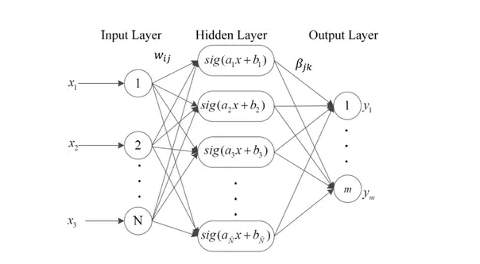

pic. source: https://medium.com/analytics-vidhya/a-gentle-introduction-to-extreme-learning-machines-elm-91bb793effa8

Рассмотрим вкратце алгоритм ELM на примере сети с одним скрытым слоем (см. рис.),  более подробно познакомиться можно здесь [1-3]. Пусть обучающий набор представляет собой:
$$[\mathrm{X}, \mathrm{Y}]=\left\{\mathrm{x}_{\mathrm{i}}, \mathrm{y}_{\mathrm{i}}\right\}(\mathrm{i}=1,2, \ldots \ldots, \mathrm{Q}),$$
где входные признаки определены как $\mathrm{X}=\left[\mathrm{x}_1, \mathrm{x}_2, \ldots \ldots, \mathrm{x}_{\mathrm{Q}}\right]_{\mathrm{ixQ}} $ ,
a ответы $\mathrm{Y}=\left[\mathrm{y}_1, \mathrm{y}_2, \ldots \ldots, \mathrm{y}_{\mathrm{Q}}\right]_{\mathrm{jxQ}} $  или в матричной форме входные данные: $$X=\left[\begin{array}{cccc}
x_{11} & x_{12} & \cdots & x_{1 Q} \\
x_{21} & x_{22} & \cdots & x_{2 Q} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n 1} & x_{n 2} & \cdots & x_{n O}
\end{array}\right],$$
и матрица ответов:
$$ Y=\left[\begin{array}{cccc}
y_{11} & y_{12} & \cdots & y_{m Q} \\
y_{21} & y_{22} & \cdots & y_{m Q} \\
\vdots & \vdots & \ddots & \vdots \\
y_{m 1} & y_{m 2} & \cdots & y_{m Q}
\end{array}\right]$$

Тогда выходная матрица скрытого слоя может быть описана:
$\mathrm{T}=\left[\mathrm{t}_1, \mathrm{t}_2, \ldots \ldots, \mathrm{t}_{\mathrm{Q}}\right]_{\mathrm{mxQ}} $
или более подробно для каждого $\mathrm{t}_j$  вектора-столбца:
$$ t_j=\left[\begin{array}{c}
t_{1 j} \\
t_{2 j} \\
\vdots \\
t_{m j}
\end{array}\right]=\left[\begin{array}{c}
\sum_{i=1}^l \beta_{i 1} g\left(w_i x_j+b_i\right) \\
\sum_{i=1}^l \beta_{i 2} g\left(w_i x_j+b_i\right) \\
\vdots \\
\sum_{i=1}^l \beta_{i m} g\left(w_i x_j+b_i\right)
\end{array}\right] \quad(j=1,2,3, \ldots, Q).$$

значения же смещений в нейронах инициализируются случайным образом, как видим матрица $\mathrm{T}$ может быть представлена в виде матричного произведения $\mathrm{H}\beta= \mathrm{T}^{\prime},$ где $\mathrm{T}^{\prime}$ транспонированная матрица $\mathrm{T}.$
Оптимальным решением в смысле минимума среднеквадратичной ошибки является решение
$\beta=\mathrm{H}^{+} \mathrm{T}^{\prime}$ [4].
На практике же используется дополнительная регуляризация для предотвращения переобучения. В случае если количество обучающих примеров значительно больше числа нейронов скрытого слоя веса вычисляются по формуле:
$$ \beta=\left(1 / \lambda+\mathrm{H}^{\mathrm{T}} \mathrm{H}\right)^{-1} \mathrm{H}^{\mathrm{T}} \mathrm{T}^{\prime}$$
в противоположном случае вычисляем с использованием формулы:
$$\beta=\mathrm{H}^{\mathrm{T}}\left(1 / \lambda+\mathrm{HH}^{\mathrm{T}}\right)^{-1} \mathrm{~T}^{\prime}.$$

Опишем эти оптимизирующее  преобразования с помощью PyTorch фреймворка

In [ ]:
class PseudoInverse(object):

  def __init__(self, params, C=1e-2, L=100):

     self.params = list(params)
     self.C = C
     self.L = L
     self.w = self.params[-1]

     self.M = torch.tensor(torch.inverse(self.C * torch.eye(self.w.size()[1])), requires_grad=False)
     self.w.data.fill_(0)

     self.is_cuda = self.w.is_cuda

     if self.is_cuda:
         self.M = self.M.cuda()

  def big(self, inputs, targets):
    xtx = torch.mm(inputs.t(), inputs)
    I = torch.eye(inputs.size()[1], requires_grad=False)

    if self.is_cuda:
     I = I.cuda()

    if self.L > 0.0:
     mu = torch.mean(inputs, dim=0, keepdim=True)
     S = inputs - mu
     S = torch.mm(S.t(), S)
     self.M = torch.tensor(torch.inverse(xtx + self.C * (I+self.L*S)), requires_grad=False)

    else:
      self.M = torch.tensor(torch.inverse(xtx + self.C *I), requires_grad=False)

    w = torch.mm(self.M, inputs.t())
    w = torch.mm(w, targets)
    self.w.data = w.t().data

  def small(self, inputs, targets):
    xxt = torch.mm(inputs, inputs.t())
    I = torch.eye(inputs.size()[0], requires_grad=False)

    if self.is_cuda:
      I = I.cuda()
    self.M = torch.tensor(torch.inverse(xxt.data + self.C * I), requires_grad=False)

    w = torch.mm(inputs.t(), self.M)
    w = torch.mm(w, targets)

    self.w.data = w.t().data

  def optimize(self, inputs, oneHotTargets):

    oneHotTargets = oneHotTargets.view(oneHotTargets.size(0),-1)
    oneHotTargets = oneHotTargets.type(torch.FloatTensor)

    if inputs.size()[0] > inputs.size()[1]:
       self.big(inputs, oneHotTargets)
    else:
       self.small(inputs, oneHotTargets)

## 2.3 ELM Neural Network

In [ ]:
class ConvELM(nn.Module):
  def __init__(self, activation='leaky_relu'):
     super(ConvELM, self).__init__()

     self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
     self.conv2 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     self.fc2 = nn.Linear(4096, 10, bias=False)
     self.activation = getattr(F, activation)

  def forward(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1, dilation=1)
    x = self.activation(x)
    x = self.conv2(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1, dilation=1)
    x = self.activation(x)

    x = x.view(-1, self.num_flat_features(x))
    x = self.fc2(x)
    return x

  def forward2hidden(self, x):
    x = self.conv1(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1, dilation=1)
    x = self.activation(x)
    x = self.conv2(x)
    x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1, dilation=1)
    x = self.activation(x)
    x = x.view(-1, self.num_flat_features(x))
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size: num_features *= s
    return num_features

## **2.4 Utility Functions**

In [ ]:
def tensor2numpy(tensor):
  return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
    return m

def train(model, ps_inverse, train_loader, num_classes) -> ConvELM:
  model.train()

  predictions =[]
  trues =[]

  for data, targets in train_loader:
    hidden_out = model.forward2hidden(data)

    one_hot_targets = F.one_hot(targets, num_classes=num_classes)
    one_hot_targets = torch.squeeze(one_hot_targets)
    one_hot_targets = one_hot_targets.type(torch.FloatTensor)

    ps_inverse.optimize(inputs=hidden_out, oneHotTargets=one_hot_targets)
    output = model(data)
    pred = np.argmax(tensor2numpy(output), axis=1)

    trues.append(tensor2numpy(targets))
    predictions.append(pred)

  targets = np.concatenate(trues).ravel()
  predictions = np.concatenate(predictions).ravel()
  print(f"Train accuracy: {accuracy_score(targets, predictions):.2f}")
  return model

def test(model, test_loader) -> None:
  model.eval()

  predictions = []
  trues = []

  for data, targets in test_loader:
    output = model(data)
    pred = np.argmax(tensor2numpy(output), axis=1)

    trues.append(tensor2numpy(targets))
    predictions.append(pred)

  targets = np.concatenate(trues).ravel()
  predictions = np.concatenate(predictions).ravel()
  print(f"Test accuracy: {accuracy_score(targets, predictions):.2f}")
  print(classification_report(targets, predictions))


## **2.5 Training and Testing**

In [ ]:
#загрузим сразу весь датасет в один батч)
TRAIN_BATCH_SIZE = 13632

TEST_BATCH_SIZE = 1000

N_CLASSES = 10
IMG_SZ = 28

elm = ConvELM()
elm.apply(init_weights)
optimizer = PseudoInverse(params=elm.parameters(), C=0.01, L=2)

train_loader, test_loader =\
 fmnist_dataloaders(train_batch_sz=TRAIN_BATCH_SIZE,
                                                  test_batch_sz=TEST_BATCH_SIZE)

elm = train(elm, optimizer, train_loader, N_CLASSES)
test(elm, test_loader)

Мы совсем плохо предсказываем рубашки попробуем улучшить качество предсказания на тестовой выборке с помощью ансамбля моделей

## **2.5 Ensembles Training and Testing**

Для тестирования ансамбля моделей требуется переписать функцию тестирования качества модели

In [ ]:
def test_ensemble(models, test_loader) ->None:
  models = [model.eval() for model in models]

  predictions = []
  trues = []
  for data, targets in test_loader:
    model_preds = []

    for model in models:
      output = model(data)
      pred = output.max(1)[1]
      model_preds.append(pred.unsqueeze(1))

    model_preds = torch.cat(model_preds, dim=1).cpu().numpy()

    for ans in model_preds:
      predictions.append(int(np.bincount(ans).argmax()))
    trues.append(tensor2numpy(targets))

  targets = np.concatenate(trues).ravel()
  predictions = np.array(predictions)
  print(f"Test accuracy: {accuracy_score(targets, predictions):.2f}")
  print(classification_report(targets, predictions))

Собственно сам скрипт обучения и тестирования ансамбля

In [ ]:
  ENSEMBLE_SIZE = 20
  activations = ['leaky_relu'] * ENSEMBLE_SIZE
  models = [ConvELM(activation=activation) for activation in activations]
  models = [model.apply(init_weights) for model in models]
  optimizers = [PseudoInverse(params=model.parameters()) for model in models]
  train_loader, test_loader =\
   fmnist_dataloaders(train_batch_sz=TRAIN_BATCH_SIZE,
                                                test_batch_sz=TEST_BATCH_SIZE)
  trained_models =[]
  for i, (model, optimizer) in enumerate(zip(models, optimizers)):
      trained_models += [train(model, optimizer, train_loader, num_classes=N_CLASSES)]

  test_ensemble(models, test_loader)

И ожидаемо качество предсказание ансамбля выше чем у одиночной модели

# **3. Metric Approach**

## **3.1 Faiss KNN**

Для реализации kNN будем использовать библиотеку faiss для быстрого приближенного сопоставления векторов относительно большой размерности 512 компонент

In [ ]:
class FAISSKNeighbors:
  def __init__(self, k=5):
    self.index = None
    self.y = None
    self.k = k

  def fit(self, X, y):
    self.index = faiss.IndexFlatL2(X.shape[1])
    self.index.add(X.astype(np.float32))
    self.y = y

  def predict(self, X):
    distances, indices = self.index.search(X.astype(np.float32), k=self.k)
    votes = self.y[indices]
    predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
    return predictions

## **3.2 Visual Words Dictionary Functions**

In [ ]:
IMG_SZ = 224

def prepare_feature_extractor(backbone='resnet34'):
    extractor = timm.create_model(backbone, pretrained=True, in_chans=1, num_classes=0)
    extractor.eval()
    return extractor

def extract_features(img, extractor,  normalize=True):
    feats = extractor(img)
    feats = feats.detach().cpu().numpy() if feats.requires_grad else feats.cpu().numpy()
    feats_flat = feats.flatten()
    if normalize:
        feats_flat = feats_flat / np.linalg.norm(feats_flat)
    return feats_flat

def create_vwords_dict(path, fextractor, img_sz=(IMG_SZ, IMG_SZ)):
   np_data = read_ml_data(path)
   visual_words = {"labels":[], "features": []}

   lbls =[]
   feats=[]

   for idx in range(np_data.shape[0]):
       img = np_data[idx, 1:]
       lbl = int(np_data[idx, 0])

       img = np.reshape(img, (28, 28))
       img = cv2.resize(img, img_sz)

       out_tensor = torch.from_numpy(np.array(img)).float() / 255.0
       out_tensor = torch.unsqueeze(out_tensor, dim=0)
       out_tensor = torch.unsqueeze(out_tensor, dim=0)

       feats.append(extract_features(out_tensor, fextractor))
       lbls.append(lbl)

   visual_words["labels"] = np.array(lbls)
   visual_words["features"] = np.array(feats)

   return visual_words

## **3.3 kNN Train and Testing**

In [ ]:
fextractor = prepare_feature_extractor()
kNN = FAISSKNeighbors()

#загружаем данные из ранее сериализованных массивов изображений
vwords_train = create_vwords_dict("train_data.npy", fextractor)
vwords_test = create_vwords_dict("test_data.npy", fextractor)

features = np.concatenate((vwords_train["features"], vwords_test["features"]), axis=0)
labels = np.concatenate((vwords_train["labels"], vwords_test["labels"]), axis=0)

kNN.fit(features, labels)
preds = kNN.predict(vwords_test["features"])
score = accuracy_score(vwords_test["labels"], preds)
print(f"Accuracy: {score:.2f}")

# **4. Conclusion**

Использование методов без обратного распространения ошибки вполне допустимо для практической классификации изображений на приемлемом уровне точности. Повышение точности классификации возможно путем дополнительного “нелинейного” преобразования данных, например UMAP https://umap-learn.readthedocs.io/en/latest/  и (или) использованием стратегий по типу One-vs-the-Rest или One-vs-One